In [1]:
import os
import sys
import argparse

print(os.getcwd())
os.chdir("../../")
os.getcwd()

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

/data01/dl23vitcas/dl_project/src/single_task_object_detection
config/single_task_object_detection.yaml


In [2]:
from config_experiments import config
from torchvision.transforms import transforms
from dataloader import VOC08Attr
import matplotlib.pyplot as plt
from model import ObjectDetectionModel
from utils import set_device
import torch
from bbox_transform import resize_bounding_boxes, apply_nms
import matplotlib.patches as patches
import torchvision

In [3]:
transform_val = transform = transforms.Compose(
    [
        transforms.Resize(
            size=config["transform"]["resize_values"],
            max_size=config["transform"]["max_size"],
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [4]:
# model_path = "../dl_project/experiments/object_detection/2024-07-25_10-51-08/models/best_model_epoch_95.pth"
model_path = "../dl_project/experiments/object_detection/2024-07-28_19-23-43/models/model_epoch_75.pth"

device = set_device(config["global"]["gpu_id"])
model = ObjectDetectionModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [5]:
val_data = VOC08Attr(train=False, transform=None)
val_data_for_model = VOC08Attr(train=False, transform=transform_val)

In [6]:
def inference(idx):
    img_transform, img_size_orig_transform, _, _, _, ss_rois_transform = (
        val_data_for_model[idx]
    )
    image, img_size_orig, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    ss_rois_transform = ss_rois_transform.to(device)

    indices_batch = torch.zeros(ss_rois_transform.shape[0], device=device).unsqueeze(-1)

    cls_max_score_net, max_score_net, bboxs_net = model.prediction_img(
        img_transform, ss_rois_transform, indices_batch
    )

    bboxs_net = resize_bounding_boxes(
        bboxs_net,
        orig_size=(img_transform.shape[3], img_transform.shape[2]),
        new_size=img_size_orig_transform,
    )

    pred_bbox, pred_class, pred_score = apply_nms(
        cls_max_score_net, max_score_net, bboxs_net
    )
    pred_bbox, pred_class, pred_score = (
        pred_bbox.cpu(),
        pred_class.cpu(),
        pred_score.cpu(),
    )
    return image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score

In [7]:
def plot_inference(image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score):
    im = image
    fig, ax = plt.subplots()
    ax.imshow(im)

    for gt_el in gt_bbox:
        x_min, y_min, x_max, y_max = gt_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

    for pred_el in pred_bbox:
        x_min, y_min, x_max, y_max = pred_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    print("NET")
    for box, c, score in zip(pred_bbox, pred_class, pred_score):
        print(
            f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]}) \tscore: {score.item():.3f}"
        )

    print("\nGT")

    for box, c in zip(gt_bbox, gt_class):
        print(f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})")
    plt.show()

IDX: 458

NET
tensor([195, 143, 270, 315], dtype=torch.int32) 	 class: 2 (person) 	score: 0.989
tensor([238, 115, 341, 293], dtype=torch.int32) 	 class: 2 (person) 	score: 0.982
tensor([191, 112, 351, 178], dtype=torch.int32) 	 class: 2 (person) 	score: 0.492
tensor([406, 149, 490, 314], dtype=torch.int32) 	 class: 10 (chair) 	score: 0.972
tensor([244, 125, 487, 293], dtype=torch.int32) 	 class: 10 (chair) 	score: 0.823

GT
tensor([405, 160, 492, 313], dtype=torch.int32) 	 class: 10 (chair)
tensor([232, 117, 383, 314], dtype=torch.int32) 	 class: 2 (person)
tensor([188, 144, 276, 313], dtype=torch.int32) 	 class: 2 (person)


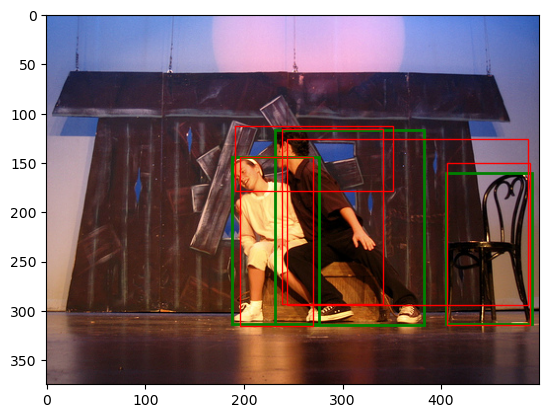

In [118]:
idx = torch.randint(low=0, high=len(val_data), size=(1,))

print(f"IDX: {idx.item()}\n")
image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score = inference(idx=idx)
plot_inference(image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score)

## Studio Recall


In [ ]:
ratio_list = []
rec_list = []
for idx in range(len(val_data)):
    _, gt_bbox, gt_class, pred_bbox, pred_class, pred_score = inference(idx=idx)
    ratio_list.append(
        gt_bbox.shape[0] / max(pred_bbox.shape[0], gt_bbox.shape[0] * 0.01)
    )
    gt_bbox = gt_bbox.tolist()
    pred_bbox = pred_bbox.tolist()
    gt_class = gt_class.tolist()
    pred_class = pred_class.tolist()
    num_gt = len(gt_bbox)
    i_pred = 0
    while i_pred < len(pred_bbox):
        i_gt = 0
        while i_gt < len(gt_bbox):
            iou = torchvision.ops.box_iou(
                torch.tensor(pred_bbox[i_pred]).unsqueeze(0),
                torch.tensor(gt_bbox[i_gt]).unsqueeze(0),
            )
            if iou.item() >= 0.5 and gt_class[i_gt] == pred_class[i_pred]:
                gt_bbox.pop(i_gt)
                gt_class.pop(i_gt)
                pred_bbox.pop(i_pred)
                pred_class.pop(i_pred)
                i_pred -= 1
                break
            i_gt += 1
        i_pred += 1
        if len(gt_bbox) == 0:
            break

    rec_list.append((num_gt - len(gt_bbox)) / num_gt)

In [ ]:
ratios = list(filter(lambda x: x < 100, ratio_list))
_ = plt.hist(list(filter(lambda x: x < 2, ratio_list)), bins=20)
print(f"gt/pred {sum(ratios) / len(ratios)}")
print(f"nopred/image{(len(ratio_list) - len(ratios)) / len(ratio_list)}")
print(f"rec avg {sum(rec_list)/len(rec_list)}")

In [ ]:
_ = plt.hist(rec_list, bins=100)

In [ ]:
from metrics import compute_mAP, view_mAP_for_class

mAP = compute_mAP(val_data_for_model, model, device)
mAP

In [ ]:
mAP["map_per_class"]

In [ ]:
torch.mean(mAP["map_per_class"])

# Test VGG


In [3]:
import torchvision
import torch
import torch.nn as nn
from torchvision.models import VGG16_Weights
from config_experiments import config
from bbox_transform import regr_to_bbox
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        rawnet = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.features = nn.Sequential(*list(rawnet.features.children())[:-1])

        # Freezare il primo layer conv
        self.features[0].weight.requires_grad = False
        self.features[0].bias.requires_grad = False

    def forward(self, input):
        return self.features(input)


class ROI_Module(nn.Module):
    def __init__(self):
        super(ROI_Module, self).__init__()

        self.roipool = torchvision.ops.RoIPool(
            output_size=(7, 7),  # Cambiare a 7x7
            spatial_scale=config["model"]["spatial_scale"],
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(
                512 * 7 * 7,  # Cambiato da 256 a 512 per VGG16
                4096,
            ),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )

    def forward(self, features, rois, ridx):
        idx_rois = torch.cat(
            (ridx, rois), dim=-1
        )  # create matrix with (batch_idx, rois(xyxy))
        res = self.roipool(features, idx_rois)
        res = res.view(res.size(0), -1)
        feat = self.classifier(res)
        return feat


class ObjectDetectionHead(nn.Module):
    def __init__(self, num_classes=config["global"]["num_classes"]):
        super().__init__()
        self.num_classes = num_classes

        self.cls_score = nn.Linear(4096, self.num_classes + 1)
        self.bbox = nn.Linear(4096, 4 * (self.num_classes + 1))

        nn.init.normal_(self.cls_score.weight, mean=0, std=0.01)
        nn.init.normal_(self.bbox.weight, mean=0, std=0.001)

        nn.init.constant_(self.cls_score.bias, 0)
        nn.init.constant_(self.bbox.bias, 0)

    def forward(self, feat):
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat).view(-1, self.num_classes + 1, 4)
        return cls_score, bbox


class ObjectDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone()
        self.roi_module = ROI_Module()
        self.obj_detect_head = ObjectDetectionHead(
            num_classes=config["global"]["num_classes"]
        )

    def forward(self, x, rois, ridx):
        out = self.backbone(x)
        out = self.roi_module(out, rois, ridx)
        cls_score, bbox = self.obj_detect_head(out)
        return cls_score, bbox

    def prediction_img(self, img, rois, ridx):
        self.eval()
        with torch.no_grad():
            score, tbbox = self(img, rois, ridx)
        _, _, heigth, width = img.shape
        score = nn.functional.softmax(score, dim=-1)
        max_score, cls_max_score = torch.max(score, dim=-1)

        bboxs = regr_to_bbox(rois, tbbox, (heigth, width))

        bboxs = bboxs[torch.arange(cls_max_score.shape[0]), cls_max_score]
        # bboxs = self.unnormalize_bbox(bboxs)
        return cls_max_score, max_score, bboxs

    def calc_loss(
        self,
        probs,
        bbox,
        labels,
        gt_bbox,
    ):
        # cel = nn.CrossEntropyLoss(weight=self.get_class_weigths().to(labels.device), label_smoothing=0.1)
        cel = nn.CrossEntropyLoss()

        sl1 = nn.SmoothL1Loss(reduction="none")
        loss_sc = cel(probs, labels)

        # gt_bbox = self.normalize_bbox(gt_bbox)
        mask = (labels != 0).bool()
        t_u = bbox[torch.arange(bbox.shape[0]), labels]
        loss_loc = (
            torch.sum(torch.sum(sl1(t_u[mask], gt_bbox[mask]), dim=1), dim=0)
            / labels.shape[0]
        )

        loss_sc = config["loss"]["lmb_cls"] * loss_sc
        loss_loc = config["loss"]["lmb_loc"] * loss_loc
        loss = loss_sc + loss_loc
        return loss, loss_sc, loss_loc

In [4]:
device = set_device(config["global"]["gpu_id"])
model = ObjectDetectionModel().to(device)

In [5]:
model

ObjectDetectionModel(
  (backbone): Backbone(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla